# Feb 15, 2024: svinet analysis

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd 
import pickle 
from itertools import product, permutations
from tqdm import tqdm as tqdm
from copy import deepcopy
from scipy import stats
from multiprocessing import Pool
from sympy.utilities.iterables import multiset_permutations
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres
from hierarch.resampling import Bootstrapper

# networks
import networkx as nx
import ants
from nipype.interfaces import afni

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240227-17:02:47,297 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.type = 'columnar'
args.roi_size = 'x'
args.maintain_symmetry = True
args.brain_div = 'ca2'
args.num_rois = 226

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.num_comms = 7
args.thresh = 0.15
args.num_resamples = 50

PARCELS_path = f'{os.environ["HOME"]}/mouse_dataset/parcels'
BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi'
COMM_path = f'{BASE_path}/{DESC}/svinets/k-{args.num_comms}'
NPY_path = f'{BASE_path}/{DESC}/npy_files'
ESTM_path = f'{BASE_path}/{DESC}/estimates'
os.system(f'mkdir -p {ESTM_path}')

0

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [5]:
import glob

def get_dataset(args, files):
    def get_comms(file):
        comms_ = np.loadtxt(file)
        comms = np.zeros((args.num_rois, args.num_comms))
        comms[comms_[:, 1].astype(int), :] = comms_[:, 2:]
        return comms

    dataset_df = []

    for file in tqdm(files):
        ssr = file.split('/')[-3].split('_')
        seed = file.split('/')[-2].split('-')[-1]
        # if int(seed) > 25: continue
        sub, ses, run = [ssr[i].split('-')[-1] for i in range(3)]
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'seed':[int(seed)], 
            'mem_mat':[get_comms(file)],
        })
        dataset_df.append(df)
    dataset_df = pd.concat(dataset_df)
    return dataset_df.sort_values(
        by=['sub', 'ses', 'run', 'seed'],
    ).reset_index(drop=True)

dataset_ssrs_df = get_dataset(
    args, 
    files=glob.glob(f'{COMM_path}/**/groups.txt', recursive=True)
)
# dataset_ssrs_df

100%|██████████| 5950/5950 [00:04<00:00, 1385.78it/s]


In [6]:
args.num_subs = len(dataset_ssrs_df['sub'].unique())
args.num_sess = len(dataset_ssrs_df['ses'].unique())

In [7]:
def reference_comms(args, X):
    X = np.concatenate(X, axis=-1)
    kmeans = KMeans(
        n_clusters=args.num_comms, 
        init='k-means++', n_init=50,
        random_state=args.SEED
    ).fit(X=X.T)
    print('found reference')
    return kmeans.cluster_centers_.T # num_rois x num_comms

def align_two_partitions(args, source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    D = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(D)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(args, X):
    comm_cntrs = reference_comms(args, X)
    
    for idx, comms in tqdm(enumerate(X)):
        (
            comms, 
            best_pi,
        ) = align_two_partitions(
            args, 
            source_comms=comms, 
            target_comms=comm_cntrs
        )
        X[idx] = comms * (comms > args.thresh)
        X[idx] = np.round(X[idx], decimals=3)
    return X

def bootstrap(args, df, cols, estim_cols):
    mdf = df.set_index(cols)
    index = np.array(mdf.index.to_list())
    index = index if index.ndim > 1 else np.expand_dims(index, axis=-1)
    index = np.hstack([index, np.ones((len(df),1))])
    
    boot = Bootstrapper(random_state=args.SEED, kind='indexes')
    boot.fit(index, skip=None)
    boot_means = [[] for _ in estim_cols]
    for _ in np.arange(args.num_resamples):
        index_boot = np.squeeze(boot.transform(index, start=0)[:, :-1]).tolist()
        mdf_ = mdf.loc[index_boot]
        for idx, estim_col in enumerate(estim_cols):
            estim = mdf_[estim_col].values
            boot_means[idx].append(np.mean(estim))
    return boot_means

def get_statistic(args, df, estim_cols):
    estims = []
    for idx, estim_col in enumerate(estim_cols):
        estim = np.mean(df[estim_col].to_list(), axis=0)
        estims.append(estim)
    return estims

def rescale(X):
    X /= np.expand_dims(np.sum(X, axis=-1), axis=-1)
    X = np.nan_to_num(X)
    X = np.round(X, decimals=3)
    return X

def combine_within_df_groups(
    args, main_df, 
    fixed_cols=['sub', 'ses', 'run'],
    index_cols=['sub', 'ses', 'run', 'seed'], 
    estim_cols=['mem_mat'],
):
    groups = main_df.groupby(by=fixed_cols)
    dfs = []
    for key, group in tqdm(groups):
        key = [key] if not type(key) == tuple else list(key)
        assert len(key) == len(fixed_cols)
        var_cols = [
            c 
            for c in index_cols 
            if c not in fixed_cols
        ] # variable cols in the index
        
        '''
        X = bootstrap(
            args, 
            df=group,
            cols=var_cols,
            estim_cols=estim_cols,
        )
        X = [np.mean(x, axis=0).round(3) for x in X]
        X = [rescale(x) for x in X]
        '''
        X = get_statistic(
            args, 
            df=group,
            estim_cols=estim_cols,
        )
        X[0] = rescale(X[0])
        
        data = key + X
        cols = fixed_cols + estim_cols
        df = pd.DataFrame({
            k:[v] 
            for k, v in zip(cols, data)
        })
        dfs.append(df)
    dataset_df = pd.concat(dfs)
    return dataset_df.reset_index(drop=True)

In [8]:
dataset_ssrs_df['mem_mat'] = align_partitions(args, dataset_ssrs_df['mem_mat'].to_list())

found reference


5950it [00:04, 1421.05it/s]


In [9]:
main_df = dataset_ssrs_df
# main_df = combine_within_df_groups(
#     args, 
#     main_df=dataset_ssrs_df,
#     fixed_cols=['sub', 'ses', 'run'],
# )
estim_cols = ['mem_mat']
index_cols = [c for c in main_df.columns if c not in estim_cols]
estim_cols, index_cols

(['mem_mat'], ['sub', 'ses', 'run', 'seed'])

In [19]:
args.binwidth = 0.1
args.binrange = [0.2, 1.0]
def membership_proportions(X):
    bins = int((args.binrange[1] - args.binrange[0]) / args.binwidth)
    H = []
    for idx_comm in range(args.num_comms):
        y, _ = np.histogram(X[:, idx_comm], bins=bins, range=args.binrange)
        y = y / np.sum(y)
        H.append(y)
    H = np.nan_to_num(H)
    H = np.array(H).round(3)
    x = np.arange(args.binrange[0]+args.binwidth/2, args.binrange[1], args.binwidth)
    return H # num_comms x num_bins

main_df['hist_props'] = main_df['mem_mat'].apply(membership_proportions)
estim_cols += ['hist_props']
index_cols = [c for c in main_df.columns.to_list() if c not in estim_cols]

In [20]:
def entropy(X):
    ent = stats.entropy(X, base=2, axis=-1) / np.log2(args.num_comms)
    ent = np.nan_to_num(ent)
    return ent, stats.rankdata(ent) / X.shape[0]

# main_df['entropy'] = main_df['mem_mat'].apply(entropy)
ents = main_df['mem_mat'].apply(entropy)
main_df['entropy'] = list(zip(*ents))[0]
main_df['rank_entropy'] = list(zip(*ents))[1]

estim_cols += ['entropy', 'rank_entropy']
index_cols = [c for c in main_df.columns.to_list() if c not in estim_cols]

In [21]:
print(index_cols, estim_cols)

# animal/subj level estimates
main_s_df = combine_within_df_groups(
    args, 
    main_df=main_df,
    fixed_cols=['sub',],
    index_cols=index_cols,
    estim_cols=estim_cols
)

['sub', 'ses', 'run', 'seed'] ['mem_mat', 'hist_props', 'entropy', 'rank_entropy', 'hist_props', 'entropy', 'rank_entropy']


100%|██████████| 10/10 [00:00<00:00, 162.97it/s]


In [22]:
def save_as_nifti(args, parcels_img, roi_labels, X, name):
    parcels = parcels_img.numpy()
    for comm in range(args.num_comms):
        comms_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            comms_img += (parcels == roi) * X[idx, comm]

        parcels_img.new_image_like(
            comms_img
        ).to_filename(f'{ESTM_path}/comm{comm}.nii.gz')

    out_file = f'{ESTM_path}/{DESC}_k-{args.num_comms}_desc-{name}_meam_mbr.nii.gz'
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = [
        f'{ESTM_path}/comm{comm}.nii.gz'
        for comm in range(args.num_comms)
    ]
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline
    res = tcat.run()

    for comm in range(args.num_comms):
        try:
            os.remove(f'{ESTM_path}/comm{comm}.nii.gz')
        except:
            pass

['sub', 'ses', 'run', 'seed'] ['mem_mat', 'hist_props', 'entropy', 'rank_entropy', 'hist_props', 'entropy', 'rank_entropy']
240227-17:19:55,18 nipype.interface INFO:
	 stderr 2024-02-27T17:19:55.018107:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
240227-17:19:55,20 nipype.interface INFO:
	 stderr 2024-02-27T17:19:55.020793:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240227-17:19:55,22 nipype.interface INFO:
	 stderr 2024-02-27T17:19:55.022400:*+ WARNING: Set TR of output dataset to 1.0 s
240227-17:19:55,69 nipype.interface INFO:
	 stderr 2024-02-27T17:19:55.069518:++ elapsed time = 0.1 s


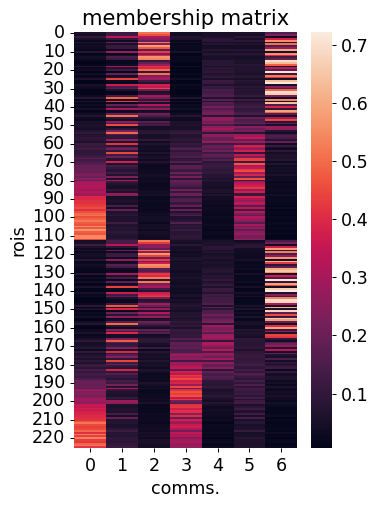

In [23]:
# group level estimates
index_cols = [c for c in main_df.columns.to_list() if c not in estim_cols]
print(index_cols, estim_cols)

X_grp_lvl = get_statistic(
    args, 
    df=main_df,
    estim_cols=estim_cols,
)
X_grp_lvl[0] = rescale(X_grp_lvl[0])


# visualize mem. mat.
fig, axs = plt.subplots(1, 1, figsize=(4, 6), dpi=90)
ax = axs
sns.heatmap(X_grp_lvl[0], ax=ax)
ax.set(title='membership matrix', xlabel='comms.', ylabel='rois')

# save as nifti
save_as_nifti(args, parcels_img, roi_labels, X_grp_lvl[0], 'svinet')

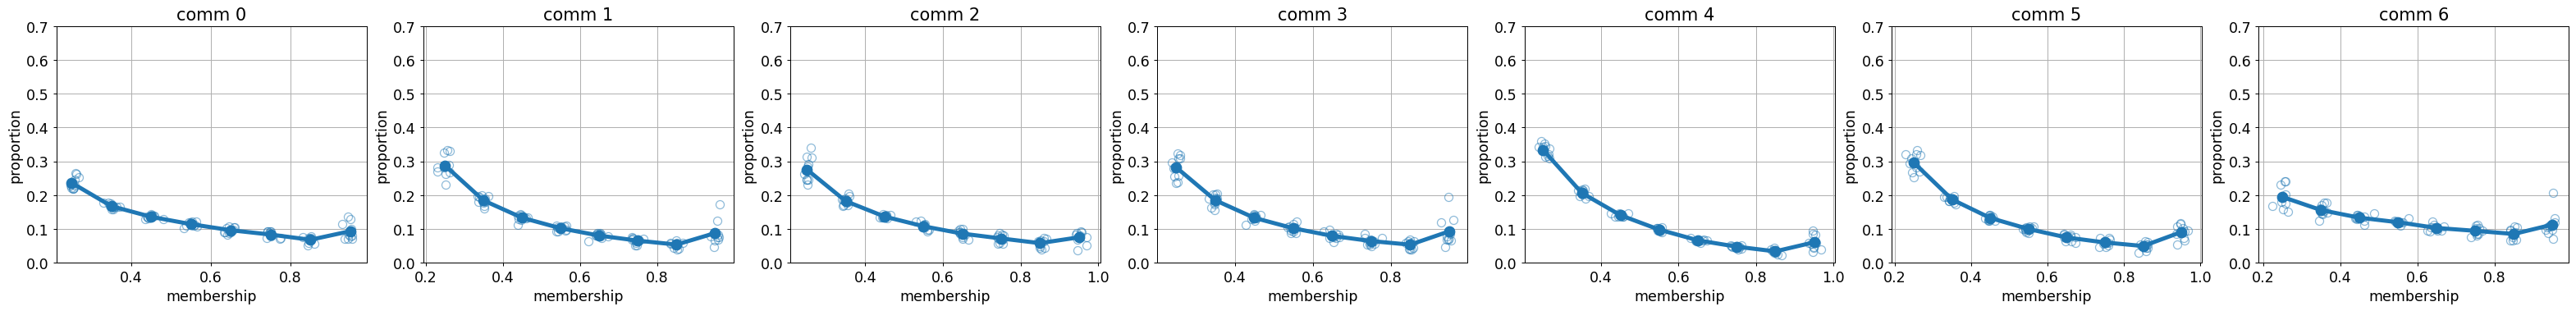

In [24]:
# MEMBERSHIP HISTOGRAMS
props_grp_lvl = X_grp_lvl[1] # comms x bins
props_subj_lvl = np.stack(main_s_df['hist_props'].values, axis=-1) # comms x bins x subs

x = np.arange(args.binrange[0]+args.binwidth/2, args.binrange[1], args.binwidth)

ncols = 7 
nrows = int(np.ceil((args.num_comms / ncols)))
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, 
    figsize=(5*ncols, 4*nrows), dpi=90, 
    sharex=False, sharey=False
)
fig.tight_layout()
for idx_comm in range(args.num_comms):
    ax = axs[idx_comm // ncols, idx_comm % ncols] if nrows > 1 else axs[idx_comm]
    ax.plot(x, props_grp_lvl[idx_comm, :], linewidth=4, markersize=10, marker='o', linestyle='-')
    for idx_sub in range(args.num_subs):
        x_ = x + 0.01*np.random.randn(x.shape[0])
        ax.plot(
            x_, props_subj_lvl[idx_comm, :, idx_sub], 
            linewidth=2, linestyle='', 
            markersize=8, marker='o', fillstyle='none',
            alpha=0.5, color='tab:blue'
        )
    ax.set(title=f'comm {idx_comm}', ylabel='proportion', ylim=[0.0, 0.7])
    if idx_comm // ncols == nrows-1: ax.set(xlabel='membership')
    ax.grid(True)

[Text(0.5, 1.0, 'rank entropy'), Text(0.5, 0, 'rank entropy')]

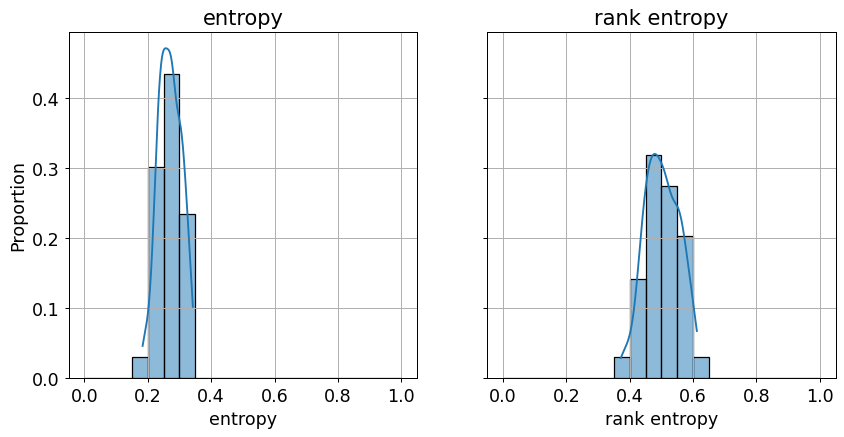

In [25]:
# MEMBERSHIP ENTROPIES
# save as nifti
def save_ent(args, parcels, ent, desc):
    ent_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels):
        ent_img += (parcels == roi) * ent[idx]

    out_file = f'{ESTM_path}/{DESC}_k-{args.num_comms}_desc-{desc}.nii.gz'
    try:
        os.remove(out_file)
    except:
        pass

    parcels_img.new_image_like(
        ent_img
    ).to_filename(out_file)
    return None

ent = X_grp_lvl[2]
rank_ent = X_grp_lvl[3]
save_ent(args, parcels, ent, 'entropy')
save_ent(args, parcels, rank_ent, 'rank_entropy')

fig, axs = plt.subplots(1, 2, figsize=(11, 5), dpi=90, sharey=True)
ax = axs[0]
sns.histplot(ent, stat='proportion', binrange=[0.0, 1.0], binwidth=0.05, kde=True, ax=ax)
ax.grid(True)
ax.set(title='entropy', xlabel='entropy')
ax = axs[1]
sns.histplot(rank_ent, stat='proportion', binrange=[0.0, 1.0], binwidth=0.05, kde=True, ax=ax)
ax.grid(True)
ax.set(title='rank entropy', xlabel='rank entropy')

In [26]:
main_df

,sub,ses,run,seed,mem_mat,hist_props,entropy,rank_entropy
0,1,1,1,1,"[[0.0, 0.26, 0.232, 0.152, 0.0, 0.296, 0.0], [...","[[0.214, 0.268, 0.143, 0.161, 0.125, 0.071, 0....","[0.6985357575063287, 0.3562042478120539, 0.546...","[0.9823008849557522, 0.6106194690265486, 0.845..."
1,1,1,1,2,"[[0.0, 0.0, 0.0, 0.401, 0.0, 0.195, 0.0], [0.0...","[[0.358, 0.17, 0.094, 0.113, 0.132, 0.019, 0.0...","[0.3248682449400877, 0.2809862866935322, 0.547...","[0.3407079646017699, 0.2345132743362832, 0.809..."
2,1,1,1,3,"[[0.0, 0.17, 0.271, 0.432, 0.0, 0.0, 0.0], [0....","[[0.271, 0.146, 0.104, 0.146, 0.125, 0.083, 0....","[0.5292505116457045, 0.5553743653461708, 0.334...","[0.7168141592920354, 0.8584070796460177, 0.442..."
3,1,1,1,4,"[[0.0, 0.0, 0.0, 0.157, 0.0, 0.0, 0.455], [0.0...","[[0.35, 0.133, 0.2, 0.117, 0.067, 0.1, 0.0, 0....","[0.2926149251795037, 0.262090077322399, 0.3402...","[0.2610619469026549, 0.16371681415929204, 0.42..."
4,1,1,1,5,"[[0.277, 0.0, 0.0, 0.0, 0.359, 0.0, 0.317], [0...","[[0.115, 0.165, 0.144, 0.115, 0.201, 0.065, 0....","[0.561715992215435, 0.2671155414219049, 0.3543...","[0.9911504424778761, 0.2920353982300885, 0.756..."
...,...,...,...,...,...,...,...,...
5945,10,3,7,46,"[[0.0, 0.0, 0.332, 0.0, 0.0, 0.0, 0.662], [0.0...","[[0.419, 0.14, 0.07, 0.116, 0.047, 0.093, 0.07...","[0.32734196092204765, 0.3042079979597715, 0.32...","[0.6460176991150443, 0.5176991150442478, 0.654..."
5946,10,3,7,47,"[[0.0, 0.0, 0.391, 0.0, 0.0, 0.28, 0.222], [0....","[[0.289, 0.329, 0.158, 0.066, 0.079, 0.039, 0....","[0.5505362977478987, 0.3055344126728825, 0.353...","[0.911504424778761, 0.40707964601769914, 0.676..."
5947,10,3,7,48,"[[0.0, 0.0, 0.525, 0.0, 0.0, 0.392, 0.0], [0.0...","[[0.151, 0.112, 0.132, 0.138, 0.125, 0.138, 0....","[0.3507828743383372, 0.0, 0.0, 0.0, 0.56300036...","[0.6814159292035398, 0.14601769911504425, 0.14..."
5948,10,3,7,49,"[[0.0, 0.67, 0.0, 0.0, 0.324, 0.0, 0.0], [0.0,...","[[0.404, 0.14, 0.193, 0.105, 0.07, 0.018, 0.01...","[0.3244124515203285, 0.2623766348440581, 0.335...","[0.28761061946902655, 0.09292035398230089, 0.3..."


In [27]:
main_s_df

,sub,mem_mat,hist_props,entropy,rank_entropy
0,1,"[[0.057, 0.091, 0.592, 0.058, 0.069, 0.095, 0....","[[0.26379500000000006, 0.17743166666666685, 0....","[0.20513836479788866, 0.23338299855995218, 0.2...","[0.39352876106194645, 0.4215007374631265, 0.52..."
1,2,"[[0.073, 0.127, 0.432, 0.063, 0.06, 0.09, 0.15...","[[0.22919499999999995, 0.1648416666666666, 0.1...","[0.3083074367057841, 0.258752101645809, 0.2153...","[0.5506305309734519, 0.47211283185840663, 0.41..."
2,3,"[[0.057, 0.1, 0.624, 0.037, 0.039, 0.046, 0.09...","[[0.21970142857142866, 0.15829857142857143, 0....","[0.18223779962170425, 0.2762362960729661, 0.18...","[0.39627054361567576, 0.5421428571428564, 0.40..."
3,4,"[[0.034, 0.159, 0.626, 0.013, 0.048, 0.035, 0....","[[0.22216333333333324, 0.166435, 0.13985666666...","[0.23717471786583214, 0.20986317830505696, 0.2...","[0.4537131268436576, 0.4122971976401175, 0.469..."
4,5,"[[0.033, 0.098, 0.437, 0.022, 0.058, 0.031, 0....","[[0.22888727272727274, 0.16425272727272733, 0....","[0.26803960770127805, 0.21204919925604016, 0.2...","[0.48707562349155337, 0.3888696701528558, 0.44..."
5,6,"[[0.058, 0.214, 0.504, 0.071, 0.029, 0.022, 0....","[[0.22253666666666666, 0.16781999999999983, 0....","[0.18151745080450932, 0.218191732228693, 0.241...","[0.3815671091445428, 0.4424631268436579, 0.479..."
6,7,"[[0.019, 0.125, 0.371, 0.015, 0.058, 0.012, 0....","[[0.2640781818181819, 0.17761272727272734, 0.1...","[0.25700940270436445, 0.24166897324448253, 0.2...","[0.47827835880933217, 0.4526427996781979, 0.47..."
7,8,"[[0.076, 0.042, 0.448, 0.004, 0.072, 0.124, 0....","[[0.22020363636363624, 0.15895272727272727, 0....","[0.2245842080996902, 0.18776022785585586, 0.20...","[0.4789179404666127, 0.4353580048270312, 0.457..."
8,9,"[[0.118, 0.094, 0.569, 0.097, 0.038, 0.026, 0....","[[0.24557333333333328, 0.17479500000000012, 0....","[0.2746018978436006, 0.2298399474544883, 0.226...","[0.49038716814159217, 0.41549041297935047, 0.4..."
9,10,"[[0.041, 0.107, 0.465, 0.033, 0.085, 0.121, 0....","[[0.2525500000000002, 0.1658983333333333, 0.13...","[0.2234401845643748, 0.20875726579732634, 0.25...","[0.4159771386430668, 0.4078650442477876, 0.462..."
